# Geekbench benchmark on Android

Geekbench4 is an app offering several benchmarks to run on android smartphones. The one used in this notebook is the '**CPU**' benchmark, which runs several workloads that follow the lines of what is commonly run by smartphones (AES, JPEG codec, FFT, and so on). The benchmark runs all the tests in '**Single-Core**' mode as well as in '**Multi-Core**' in order to compare the single-thread and multi-thread performances of the device.

**Do note that the benchmark will attempt to upload its results, which includes some hardware information**

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-11-29 16:11:59,559 INFO    : root         : Using LISA logging configuration:
2017-11-29 16:11:59,561 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('schedutil')
    
    # Get workload
    wload = Workload.getInstance(te, 'Geekbench')
    
    # Run Geekbench workload
    wload.run(te.res_dir, test_name='CPU', collect='ftrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

#     # Target platform and board
#     "platform"     : 'android',
#     "board"        : 'pixel',
    
#     # Device
#     "device"       : "0123456789ABCDEF",
    
#     # Android home
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/steven/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Folder where all the results will be collected
    "results_dir" : datetime.datetime.now()\
                    .strftime("Geekbench_example_" + '%Y%m%d_%H%M%S'),

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "cpu_capacity",
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-11-29 16:12:19,606 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2017-11-29 16:12:19,608 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-11-29 16:12:19,609 INFO    : TestEnv      : External tools using:
2017-11-29 16:12:19,611 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/android-sdk
2017-11-29 16:12:19,612 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2017-11-29 16:12:19,613 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-11-29 16:12:19,615 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-11-29 16:12:19,616 INFO    : TestEnv      : Connection settings:
2017-11-29 16:12:19,617 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-11-29 16:12:21,370 INFO    : TestEnv      : Initializing target workdir:
2017-11-29 16:12:21,372 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-11-29 16:12:22,87

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Geekbench - CPU** experiment.

In [6]:
# Initialize Workloads for this test environment
results = experiment()

2017-11-29 16:12:27,210 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.tencent.tmgp.sgame', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.vending', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.rovio.angrybirds', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.google.android.vr.home', 'com.android.providers.settings', 'com.android.sharedstorageb

2017-11-29 16:17:43,145 INFO    : Geekbench    : FTrace STOP
2017-11-29 16:17:45,729 INFO    : System       : am force-stop com.primatelabs.geekbench
2017-11-29 16:17:46,550 INFO    : Screen       : Set orientation: AUTO
2017-11-29 16:17:47,690 INFO    : Screen       : Set brightness: AUTO


## Results analysis

Geekbench4 uses a baseline score of 4000, which is the benchmark score of an Intel Core i7-6600U. Higher scores are better, with double the score indicating double the performance. You can have a look at the results for several android phones here https://browser.primatelabs.com/android-benchmarks

In [8]:
class Geekbench(object):
    """
    Geekbench json results parsing class
    """
    def __init__(self, filepath):
        with open(filepath) as fd:
            self.__json = json.loads(fd.read())
        
        self.benchmarks = {}
        for section in self.__json["sections"]:
            self.benchmarks[section["name"]] = section
            for workload in section["workloads"]:
                self.benchmarks[section["name"]][workload["name"]] = workload     
            
    def name(self):
        """Get a human-readable name for the geekbench run
        """
        gov = ""
        build = ""
        for metric in self.__json["metrics"]:
            if metric["name"] == "Governor":
                gov = metric["value"]
            elif metric["name"] == "Build":
                build = metric["value"]

        return "[build]=\"{}\" [governor]=\"{}\"".format(build, gov)
    
    def benchmarks_names(self):
        """Get a list of benchmarks (e.g. Single-Core, Multi-Core) found in the run results        
        """
        return [section["name"] for section in self.__json["sections"]]
    
    def workloads_names(self):
        """Get a list of unique workloads (e.g. EAS, Dijkstra) found in the run results
        """
        return [workload["name"] for workload in self.benchmarks.values()[0]["workloads"]]
    
    def global_scores(self):
        """Get the overall scores of each benchmark
        """
        data = {}
        for benchmark in self.benchmarks_names():
            data[benchmark] = self.benchmarks[benchmark]["score"]
        return data
        
    def detailed_scores(self):
        """Get the detailed workload scores of each benchmark
        """
        benchmark_fields = ["score", "runtime_mean", "rate_string"]
        benches = {}
        benchmarks = self.benchmarks_names()
        workloads = self.workloads_names() 
        
        for benchmark in benchmarks:
            data = {}
            for workload in workloads:
                data[workload] = {}
                for field in benchmark_fields:
                    data[workload][field] = self.benchmarks[benchmark][workload][field]        
            benches[benchmark] = data
            
        return benches

In [9]:
def display_bench_results(geekbench, detailed=False):
    print "===== Global results ====="
    
    scores = geekbench.global_scores()
    
    # Build dataframe for display
    row = []
    for bench_type, score in scores.iteritems():
        row.append(score)
        
    df = pd.DataFrame(data=row, index=scores.keys(), columns=["Global score"])
    display(df)
    
    if not detailed:
        return
    
    print "===== Detailed results ====="
    
    scores = geekbench.detailed_scores()
    
    for benchmark, results in geekbench.detailed_scores().iteritems():
        print "----- {} benchmark -----".format(benchmark)
        # Build dataframe for display
        data = []
        idx = []
        columns = results.values()[0].keys()
        for workload, fields in results.iteritems():
            data.append(tuple(fields.values()))
            idx.append(workload)
        display (pd.DataFrame(data=data, index=idx, columns=columns))

In [10]:
for f in os.listdir(te.res_dir):
    if f.endswith(".gb4"):
        geekbench = Geekbench(te.res_dir + "/" + f)
        
        print "Analysing geekbench {}".format(geekbench.name())
        display_bench_results(geekbench, True)

Analysing geekbench [build]="hikey960-userdebug O NYC eng.stemia.20170804.094239 test-keys" [governor]="schedutil"
===== Global results =====


,Global score
Single-Core,1921
Multi-Core,4216


===== Detailed results =====
----- Single-Core benchmark -----


,score,runtime_mean,rate_string
AES,1176,0.143028,907.3 MB/sec
HDR,2124,0.582327,7.70 Mpixels/sec
Rigid Body Physics,2027,0.253060,5934.1 FPS
HTML5 Parse,1959,0.137088,8.90 MB/sec
Lua,1695,0.183161,1.74 MB/sec
Camera,2029,0.178256,5.63 images/sec
Histogram Equalization,1647,0.210368,51.5 Mpixels/sec
SQLite,1926,0.376012,53.4 Krows/sec
Face Detection,1694,0.150545,495.0 Ksubwindows/sec
Memory Copy,1502,0.483356,4.16 GB/sec


----- Multi-Core benchmark -----


,score,runtime_mean,rate_string
AES,4592,0.346029,3.46 GB/sec
HDR,5056,1.930146,18.3 Mpixels/sec
Rigid Body Physics,5192,0.823236,15199.3 FPS
HTML5 Parse,5823,0.390479,26.4 MB/sec
Lua,5964,0.504743,6.13 MB/sec
Camera,5849,0.533434,16.2 images/sec
Histogram Equalization,5940,0.484785,185.6 Mpixels/sec
SQLite,4944,1.234600,137.1 Krows/sec
Face Detection,4654,0.455122,1.36 Msubwindows/sec
Memory Copy,2217,0.690658,6.14 GB/sec


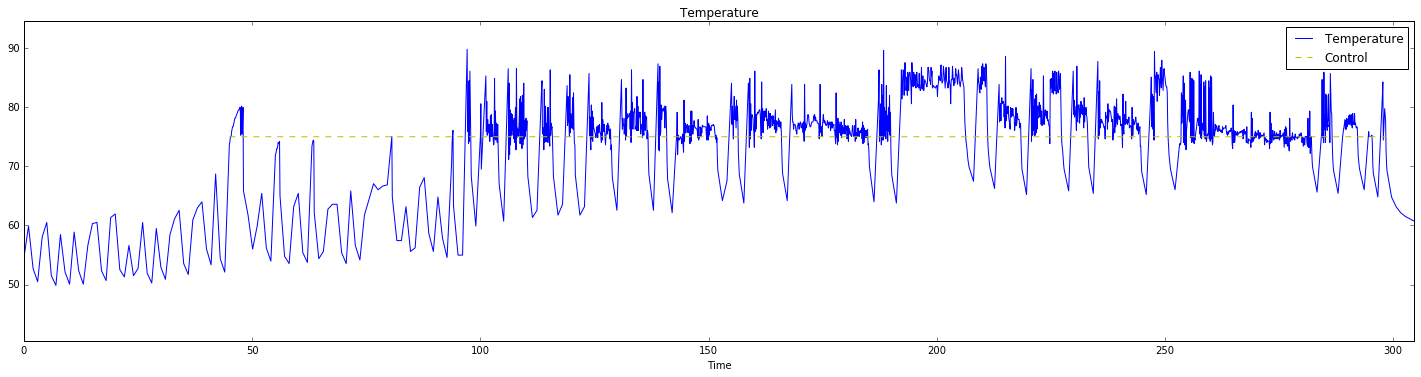

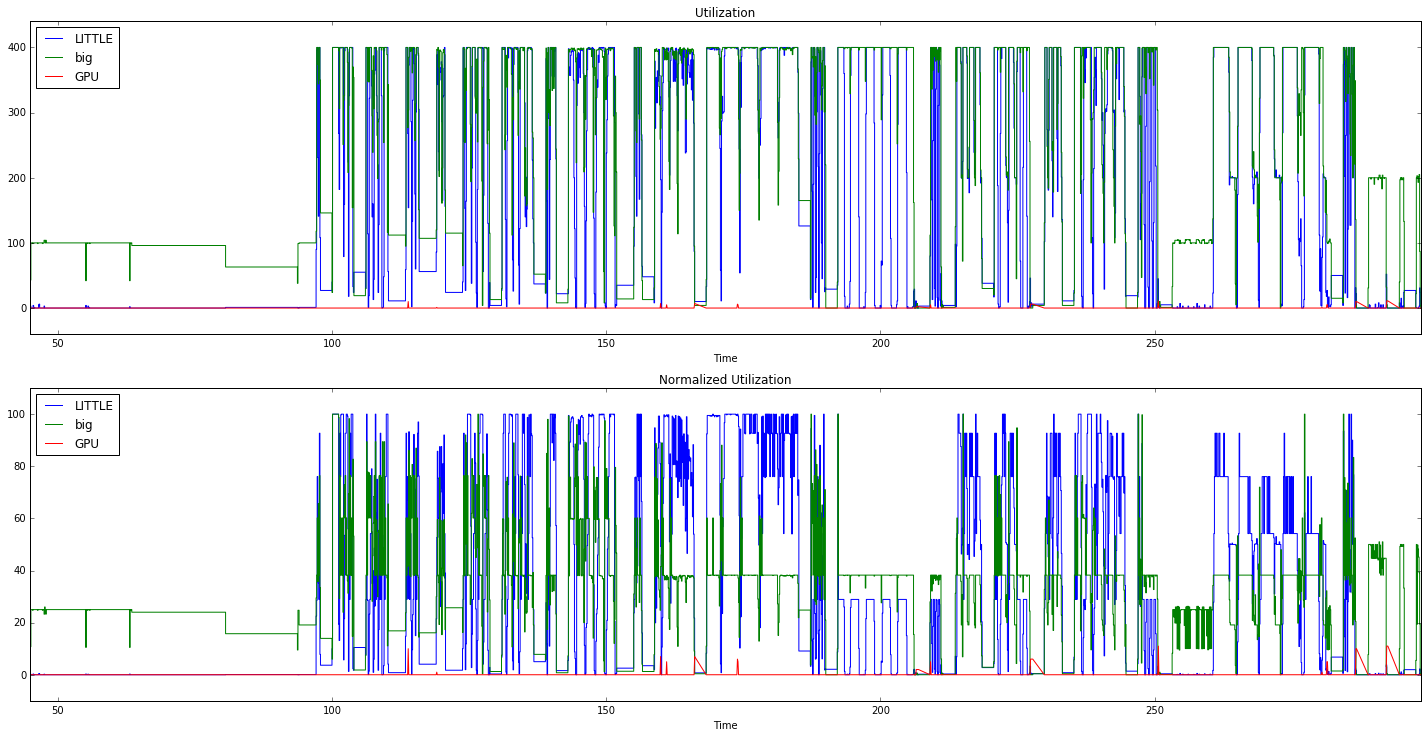

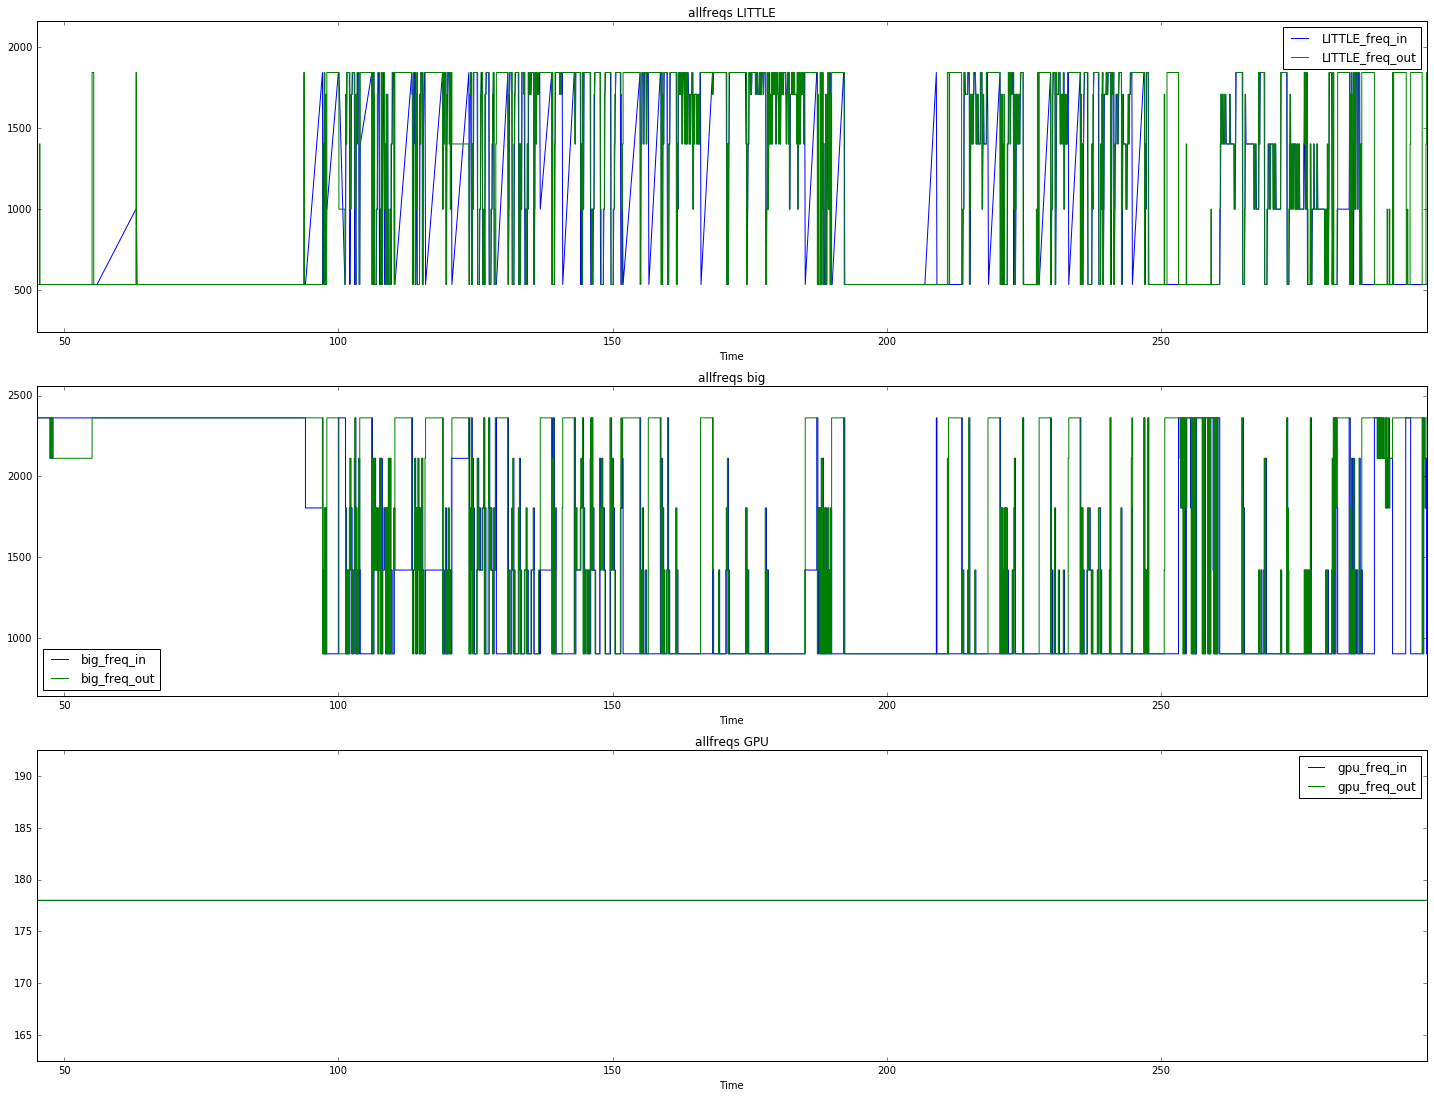

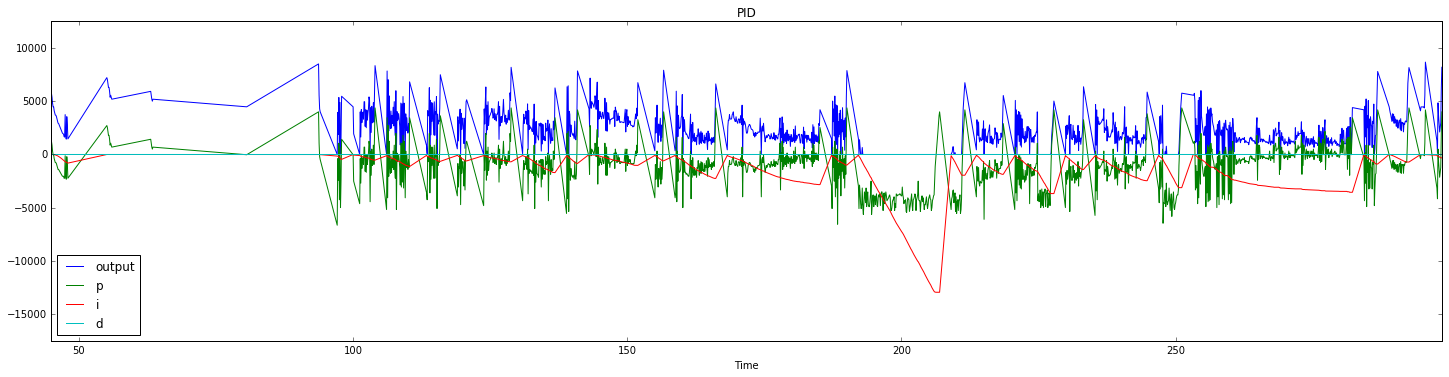

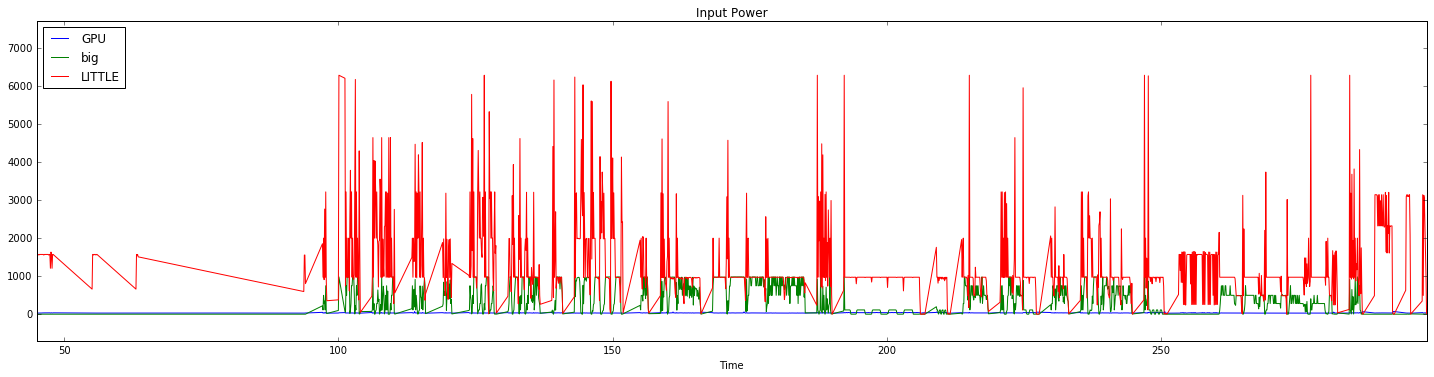

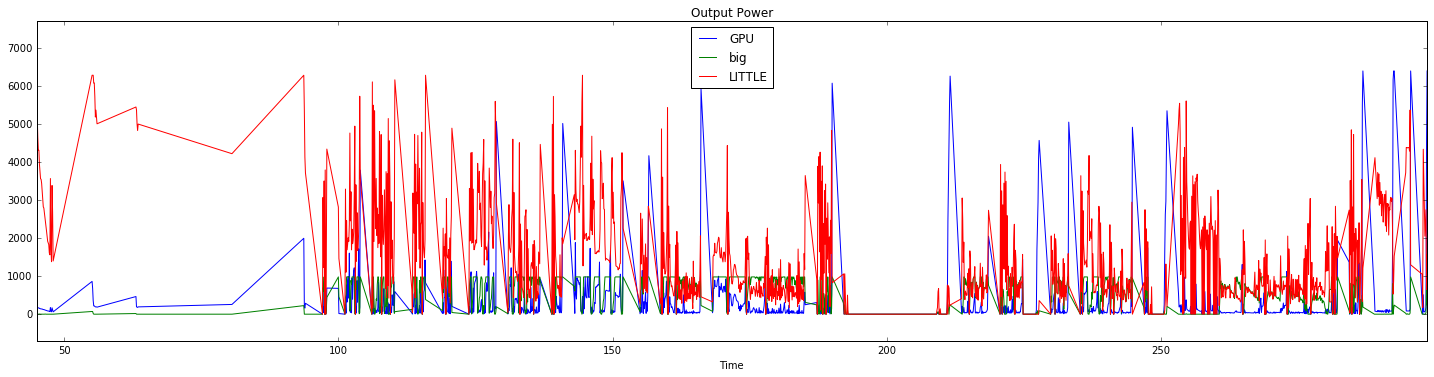

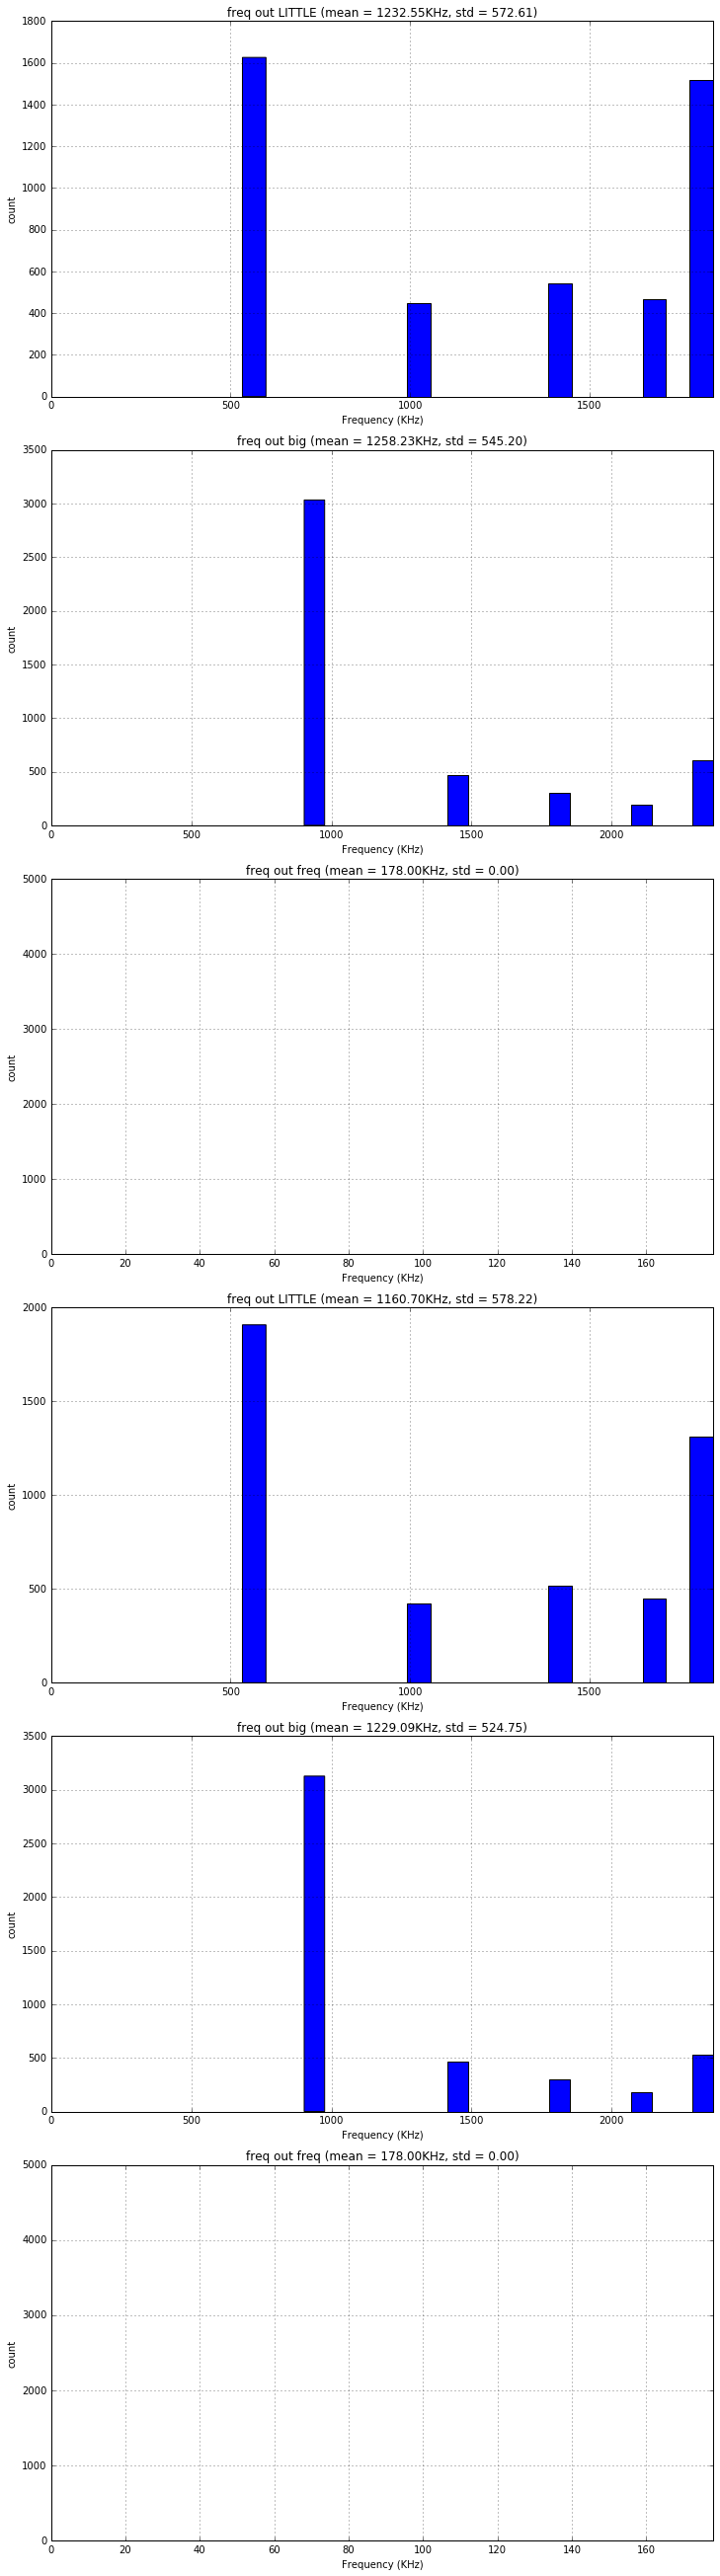

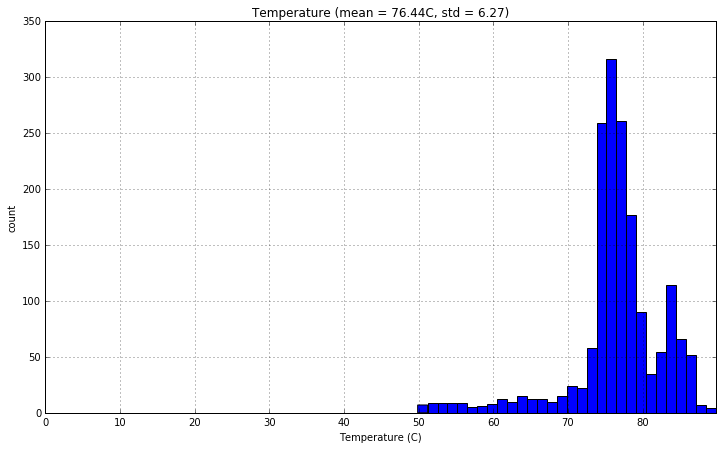

In [11]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]
trappy.summary_plots(actor_order, map_label, path=os.path.join(te.res_dir, 'trace.dat'))

## Analysing several runs

It can be interesting to compare Geekbench results with different parameters (kernel, drivers) and even different devices to gauge the impact of these parameters. As Geekbench results can vary a bit from one run to another, having a set of repeated runs is preferable.

The following section will grab the results of all the **Geekbench\_exemple\_\*** results found in the LISA results directory

In [10]:
import glob

def fetch_results():
    results_path = os.path.join(te.LISA_HOME, "results")
    
    results_dirs = [results_path + "/" + d for d in os.listdir(results_path) if d.startswith("Geekbench_example_")]
    
    res = []
    
    for d in results_dirs:
        bench_file = glob.glob("{}/*.gb4".format(d))[0]
        res.append(Geekbench(bench_file))
        
    return res

def compare_runs():
    geekbenches = fetch_results()
    
    # Pick one run to build a baseline template
    benchmarks = geekbenches[0].benchmarks_names()
    workloads = geekbenches[0].workloads_names()
    
    stats  = ["avg", "min", "max"]
    count = len(geekbenches)
    
    print "Parsing {} runs".format(count)

    
    # Initialize stats
    results = {benchmark : 
                        {"min" : sys.maxint, "max" : 0, "avg" : 0} 
               for benchmark in benchmarks}
    
    # Get all the data
    for benchmark in results.iterkeys():
        for bench in geekbenches:
            score = bench.global_scores()[benchmark]
            
            if score > results[benchmark]["max"]:
                results[benchmark]["max"] = score
                
            if score < results[benchmark]["min"]:
                results[benchmark]["min"] = score
            
            results[benchmark]["avg"] += score
        
        results[benchmark]["avg"] /= count
        
    # Convert data to Dataframe
    data = []

    for benchmark in results.iterkeys():
        row = []
        for stat in stats:
            row.append(results[benchmark][stat])
        data.append(tuple(row))
       
    df = pd.DataFrame(data, index=results.iterkeys(), columns=stats)
    
    return df

In [11]:
display(compare_runs())

IndexError: list index out of range